# Group Assignment: Demographic Prediction

## Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re # text manipulation

# function to split the data for cross-validation
from sklearn.model_selection import train_test_split

#### CLEANING LIB
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer 
#now remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
# function for transforming documents into counts
from sklearn.feature_extraction.text import CountVectorizer
# function for encoding categories
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olympiahilverda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olympiahilverda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [2]:
train=pd.read_csv('train.csv')
train.head()

,ID,keywords,age,sex
0,1,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...,62,F
1,2,restaurant:1;marrakech.shtml:1,35,M
2,3,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...,45,F
3,4,rigaud:3;laurent:3;photo:11;profile:8;photopro...,46,F
4,5,societe:1;disparition:1;proche:1;m%c3%a9lanie....,42,F


In [3]:
# Shape of training data 
print("Shape of training data (num_rows, num_columns): {}".format(train.shape))
train.head(10)

Shape of training data (num_rows, num_columns): (7265055, 4)


,ID,keywords,age,sex
0,1,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...,62,F
1,2,restaurant:1;marrakech.shtml:1,35,M
2,3,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...,45,F
3,4,rigaud:3;laurent:3;photo:11;profile:8;photopro...,46,F
4,5,societe:1;disparition:1;proche:1;m%c3%a9lanie....,42,F
5,6,portes:1;prives:1;entre:1;conso:1;mer:1;enfant...,49,F
6,8,son:1;laposte:1;forum:1;mobile:1;affich:1;forf...,47,F
7,9,location:1;preavis:1;mois:1;faq:1;modele:1;dep...,52,M
8,12,iphone:1;homme:1;vue:1;deuxieme:1;internet:1;g...,49,F
9,13,NaN,46,M


## Data Cleaning

In [4]:
# Get names of columns with missing values
cols_with_missing = [col for col in train.columns
                     if train[col].isnull().any()]
print(cols_with_missing)

['keywords']


In [5]:
# Number of missing values in each column of sample data
missing_val_count_by_column = (train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# This represents a little less than 12% of our total dataset

keywords    846396
dtype: int64


In [3]:
# Remove missing values to avoid errors (we cannot replace or infer them here)
train.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

,ID,keywords,age,sex
0,1,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...,62,F
1,2,restaurant:1;marrakech.shtml:1,35,M
2,3,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...,45,F
3,4,rigaud:3;laurent:3;photo:11;profile:8;photopro...,46,F
4,5,societe:1;disparition:1;proche:1;m%c3%a9lanie....,42,F
...,...,...,...,...
7265047,88783,suspect:2;scan:1;nouveau:1;femme:1;enlever:1;d...,30,F
7265048,340216,figaro:1,68,M
7265051,1318039,courte:2;bombee:1;coiff:3;oreal:3;tendances:28...,69,F
7265053,340230,dictionnaire:1;disparition:2;reussite:1;vue:2;...,21,M


In [7]:
# Next, the column ID is not unique, the same ID can come back many times
# However we need to predict age and gender for every single ID
train['ID'].value_counts()

933        27315
1888        4967
947         4139
3900        3123
11719       2938
           ...  
7990058        1
3748657        1
3736375        1
8039234        1
4030780        1
Name: ID, Length: 1615682, dtype: int64

In [4]:
# Aggregate keywords columns group by ID
train["keywords"] = train["keywords"].astype("str")
grp = train.groupby(['ID','age','sex']).agg(agg_keywords=('keywords', '; '.join)).reset_index()
grp.head(10)

,ID,age,sex,agg_keywords
0,1,62,F,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...
1,2,35,M,restaurant:1;marrakech.shtml:1; expositions:1;...
2,3,45,F,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...
3,4,46,F,rigaud:3;laurent:3;photo:11;profile:8;photopro...
4,5,42,F,societe:1;disparition:1;proche:1;m%c3%a9lanie....
5,6,49,F,portes:1;prives:1;entre:1;conso:1;mer:1;enfant...
6,8,47,F,son:1;laposte:1;forum:1;mobile:1;affich:1;forf...
7,9,52,M,location:1;preavis:1;mois:1;faq:1;modele:1;dep...
8,10,37,F,ambitieux:1;missions:1;foie:1;emmanuelle:1;ana...
9,11,51,F,bio:1;septembre:1;consommer:1;les:1;ses:1;mois...


In [9]:
# This works since there are around 1.6 million rows now, the number of unique ID's
grp['ID'].value_counts()

2047       1
294675     1
4351034    1
594835     1
4290129    1
          ..
1588828    1
1693281    1
5885538    1
1703524    1
2049       1
Name: ID, Length: 1615682, dtype: int64

# Gender Prediction

## Checking for unbalanced data 

In [10]:
#Unbalanced data?
n_m = np.sum(grp['sex'] == "M")
n_f = np.sum(grp['sex'] == "F")
p_m = n_m/(n_m+n_f)*100
p_f = n_f/(n_m+n_f)*100
print(f"Percentage of males in full data set: {p_m}")
print(f"Percentage of females in full data set: {p_f}")

Percentage of males in full data set: 52.997000647404626
Percentage of females in full data set: 47.002999352595374


## Selecting Smaller Sample Size

In [11]:
# Smaller sample chosen from the 1.6 million rows
mergedsample=grp[:10000]
mergedsample.head()

,ID,age,sex,agg_keywords
0,1,62,F,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...
1,2,35,M,restaurant:1;marrakech.shtml:1; expositions:1;...
2,3,45,F,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...
3,4,46,F,rigaud:3;laurent:3;photo:11;profile:8;photopro...
4,5,42,F,societe:1;disparition:1;proche:1;m%c3%a9lanie....


## Text Cleaning

In [12]:
#this part is for any text cleaning we want to do
def normalize_text(s):
    # just in case
    s = str(s)
    s = s.lower()
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W\s',' ',s)
    # make sure we didn't introduce any double spaces
    s = re.sub('\s+',' ',s)
    return s

mergedsample['text_norm'] = [normalize_text(s) for s in mergedsample['agg_keywords']]
mergedsample=mergedsample.drop(['agg_keywords'],axis=1)
mergedsample.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,ID,age,sex,text_norm
0,1,62,F,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...
1,2,35,M,restaurant:1;marrakech.shtml:1 expositions:1;b...
2,3,45,F,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...
3,4,46,F,rigaud:3;laurent:3;photo:11;profile:8;photopro...
4,5,42,F,societe:1;disparition:1;proche:1;m%c3%a9lanie....



## Gender Prediction Iteration 1: Trying different models

In [13]:
# Pull the data into vectors
vectorizer = CountVectorizer()
xsample = vectorizer.fit_transform(mergedsample['text_norm'])
encoder = LabelEncoder()
ysample = encoder.fit_transform(mergedsample['sex'])
# split into train and test sets
xs_train, xs_test, ys_train, ys_test = train_test_split(xsample, ysample, test_size=0.2)
# take a look at the shape of each of these
print(xs_train.shape)
print(ys_train.shape)
print(xs_test.shape)
print(ys_test.shape)

(8000, 96625)
(8000,)
(2000, 96625)
(2000,)


In [14]:
#Naive Bayes
nb = MultinomialNB()
nb.fit(xs_train, ys_train)
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(xs_train, ys_train)
# Random Forest 
rf = RandomForestClassifier(n_estimators=50, max_depth=None)
rf.fit(xs_train, ys_train)
# Gradient Boosted Trees
gbt = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1) 
gbt.fit(xs_train, ys_train)

r = {'Train set':[nb.score(xs_train, ys_train),dt.score(xs_train, ys_train),rf.score(xs_train, ys_train),gbt.score(xs_train, ys_train)],'test set':[nb.score(xs_test, ys_test),dt.score(xs_test, ys_test),rf.score(xs_test, ys_test),gbt.score(xs_test, ys_test)]}
Results= pd.DataFrame(r,index=['nb','dt','rf','gbt'])
Results

,Train set,test set
nb,0.76025,0.6550
dt,0.98625,0.5970
rf,0.98625,0.6500
gbt,0.66400,0.6275


## Gender Prediction Iteration 2: Removing frequencies

In [15]:
# Most words only appear once
# Adding further text cleaning require removing the frequencies. We test if it decreases the performances
mergedsample.text_norm = mergedsample.text_norm.str.replace(':',' ')
cleaningkey=mergedsample.text_norm
tokensnoalpha = cleaningkey.apply(word_tokenize)
tokensnoalpha=tokensnoalpha.apply(lambda lst: [word for word in lst if word.isalpha()])
mergedsample.text_norm=tokensnoalpha
mergedsample.head()

,ID,age,sex,text_norm
0,1,62,F,"[fibre, quoi, dangers, combien, hightech, que,..."
1,2,35,M,"[restaurant, expositions, blois, ajaccio, vill..."
2,3,45,F,"[payer, faq, taxe, habitation, macron, qui, de..."
3,4,46,F,"[rigaud, laurent, photo, profile, photoprofile..."
4,5,42,F,"[societe, disparition, proche, m, maelys, actu..."


In [16]:
# pull the data into vectors
mergedsample.text_norm = mergedsample.text_norm.astype("str")
vectorizer = CountVectorizer()
xsample2 = vectorizer.fit_transform(mergedsample['text_norm'])
encoder = LabelEncoder()
ysample2 = encoder.fit_transform(mergedsample['sex'])
xs2_train, xs2_test, ys2_train, ys2_test = train_test_split(xsample2, ysample2, test_size=0.2)
print(xs2_train.shape)
print(ys2_train.shape)
print(xs2_test.shape)
print(ys2_test.shape)

(8000, 67453)
(8000,)
(2000, 67453)
(2000,)


In [17]:
#Naive Bayes
nb2 = MultinomialNB()
nb2.fit(xs_train, ys_train)
# Decision Tree
dt2 = DecisionTreeClassifier()
dt2.fit(xs_train, ys_train)
# Random Forest 
rf2 = RandomForestClassifier(n_estimators=50, max_depth=None)
rf2.fit(xs_train, ys_train)
# Gradient Boosted Trees
gbt2 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1) 
gbt2.fit(xs_train, ys_train)

r2 = {'Train set':[nb2.score(xs_train, ys_train),dt2.score(xs_train, ys_train),rf2.score(xs_train, ys_train),gbt2.score(xs_train, ys_train)],'test set':[nb2.score(xs_test, ys_test),dt2.score(xs_test, ys_test),rf2.score(xs_test, ys_test),gbt2.score(xs_test, ys_test)]}
Results2= pd.DataFrame(r2,index=['nb2','dt2','rf2','gbt2'])
Results2

,Train set,test set
nb2,0.76025,0.6550
dt2,0.98625,0.6005
rf2,0.98625,0.6490
gbt2,0.66400,0.6275


## Gender Prediction Iteration 3: Removing Stopwords

In [18]:
#now that we don't have frequencies, we focus on text cleaning, we want to eliminate stopwords such as 'les,le,des'
mergedsample.text_norm.head(20)

0     ['fibre', 'quoi', 'dangers', 'combien', 'hight...
1     ['restaurant', 'expositions', 'blois', 'ajacci...
2     ['payer', 'faq', 'taxe', 'habitation', 'macron...
3     ['rigaud', 'laurent', 'photo', 'profile', 'pho...
4     ['societe', 'disparition', 'proche', 'm', 'mae...
5     ['portes', 'prives', 'entre', 'conso', 'mer', ...
6     ['son', 'laposte', 'forum', 'mobile', 'affich'...
7     ['location', 'preavis', 'mois', 'faq', 'modele...
8     ['ambitieux', 'missions', 'foie', 'emmanuelle'...
9     ['bio', 'septembre', 'consommer', 'les', 'ses'...
10    ['iphone', 'homme', 'vue', 'deuxieme', 'intern...
11    ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...
12    ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...
13    ['metre', 'jcms', 'prix', 'immmobilier', 'reco...
14    ['censure', 'vox', 'cible', 'societe', 'antira...
15    ['symptomes', 'profile', 'causes', 'faq', 'col...
16    ['refuser', 'deuxieme', 'maelys', 'forum', 'ce...
17    ['previsions', 'ville', 'indications', 'po

In [19]:
tokensnostopwords=tokensnoalpha.apply(lambda lst: [word for word in lst if word not in stopwords.words('french')])
mergedsample.text_norm=tokensnostopwords #this step takes a lot of time
mergedsample.text_norm.head(20)

0     [fibre, quoi, dangers, combien, hightech, rece...
1     [restaurant, expositions, blois, ajaccio, vill...
2     [payer, faq, taxe, habitation, macron, detail,...
3     [rigaud, laurent, photo, profile, photoprofile...
4     [societe, disparition, proche, maelys, actuali...
5     [portes, prives, entre, conso, mer, enfants, c...
6     [laposte, forum, mobile, affich, forfait, cons...
7     [location, preavis, mois, faq, modele, depart,...
8     [ambitieux, missions, foie, emmanuelle, anatom...
9     [bio, septembre, consommer, mois, panier, ache...
10    [iphone, homme, vue, deuxieme, internet, garde...
11        [nan, nan, nan, nan, nan, nan, nan, nan, nan]
12    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
13    [metre, jcms, prix, immmobilier, record, bat, ...
14    [censure, vox, cible, societe, antiraciste, bo...
15    [symptomes, profile, causes, faq, colite, trai...
16    [refuser, deuxieme, maelys, forum, censure, af...
17    [previsions, ville, indications, posologie

In [20]:
# pull the data into vectors
mergedsample.text_norm = mergedsample.text_norm.astype("str")
vectorizer = CountVectorizer()
xsample = vectorizer.fit_transform(mergedsample['text_norm'])
encoder = LabelEncoder()
ysample = encoder.fit_transform(mergedsample['sex'])
xs_train, xs_test, ys_train, ys_test = train_test_split(xsample, ysample, test_size=0.2)
print(xs_train.shape)
print(ys_train.shape)
print(xs_test.shape)
print(ys_test.shape)

(8000, 67366)
(8000,)
(2000, 67366)
(2000,)


In [21]:
#Naive Bayes
nb3 = MultinomialNB()
nb3.fit(xs_train, ys_train)
# Decision Tree
dt3 = DecisionTreeClassifier()
dt3.fit(xs_train, ys_train)
# Random Forest 
rf3 = RandomForestClassifier(n_estimators=50, max_depth=None)
rf3.fit(xs_train, ys_train)
# Gradient Boosted Trees
gbt3 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1) 
gbt3.fit(xs_train, ys_train)

r3 = {'Train set':[nb3.score(xs_train, ys_train),dt3.score(xs_train, ys_train),rf3.score(xs_train, ys_train),gbt3.score(xs_train, ys_train)],'test set':[nb3.score(xs_test, ys_test),dt3.score(xs_test, ys_test),rf3.score(xs_test, ys_test),gbt3.score(xs_test, ys_test)]}
Results3= pd.DataFrame(r3,index=['nb3','dt3','rf3','gbt3'])
Results3

,Train set,test set
nb3,0.743125,0.6675
dt3,0.984375,0.5920
rf3,0.984250,0.6545
gbt3,0.667875,0.6490


## Gender Prediction Iteration 4 : Stemming

In [22]:
#we perform stemming to reduce words dimensions
mergedsample.text_norm.head(30)

0     ['fibre', 'quoi', 'dangers', 'combien', 'hight...
1     ['restaurant', 'expositions', 'blois', 'ajacci...
2     ['payer', 'faq', 'taxe', 'habitation', 'macron...
3     ['rigaud', 'laurent', 'photo', 'profile', 'pho...
4     ['societe', 'disparition', 'proche', 'maelys',...
5     ['portes', 'prives', 'entre', 'conso', 'mer', ...
6     ['laposte', 'forum', 'mobile', 'affich', 'forf...
7     ['location', 'preavis', 'mois', 'faq', 'modele...
8     ['ambitieux', 'missions', 'foie', 'emmanuelle'...
9     ['bio', 'septembre', 'consommer', 'mois', 'pan...
10    ['iphone', 'homme', 'vue', 'deuxieme', 'intern...
11    ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...
12    ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'na...
13    ['metre', 'jcms', 'prix', 'immmobilier', 'reco...
14    ['censure', 'vox', 'cible', 'societe', 'antira...
15    ['symptomes', 'profile', 'causes', 'faq', 'col...
16    ['refuser', 'deuxieme', 'maelys', 'forum', 'ce...
17    ['previsions', 'ville', 'indications', 'po

In [23]:
ps = PorterStemmer()
tokenstem=tokensnostopwords.apply(lambda lst: [ ps.stem(w) for w in lst])
mergedsample.text_norm=tokenstem
mergedsample.text_norm.head(30)

0     [fibr, quoi, danger, combien, hightech, recevr...
1     [restaur, exposit, bloi, ajaccio, vill, bonapa...
2     [payer, faq, tax, habit, macron, detail, progr...
3     [rigaud, laurent, photo, profil, photoprofil, ...
4     [societ, disparit, proch, maeli, actualit, aff...
5     [port, prive, entr, conso, mer, enfant, ciel, ...
6     [lapost, forum, mobil, affich, forfait, consul...
7     [locat, preavi, moi, faq, model, depart, ide, ...
8     [ambitieux, mission, foie, emmanuel, anatomi, ...
9     [bio, septembr, consomm, moi, panier, achet, j...
10    [iphon, homm, vue, deuxiem, internet, gard, di...
11        [nan, nan, nan, nan, nan, nan, nan, nan, nan]
12    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
13    [metr, jcm, prix, immmobili, record, bat, pari...
14    [censur, vox, cibl, societ, antiracist, boudja...
15    [symptom, profil, caus, faq, colit, traitement...
16    [refus, deuxiem, maeli, forum, censur, affich,...
17    [previs, vill, indic, posologi, enghien, m

In [24]:
# pull the data into vectors
mergedsample.text_norm = mergedsample.text_norm.astype("str")
vectorizer = CountVectorizer()
xsample = vectorizer.fit_transform(mergedsample['text_norm'])
encoder = LabelEncoder()
ysample = encoder.fit_transform(mergedsample['sex'])
xs_train, xs_test, ys_train, ys_test = train_test_split(xsample, ysample, test_size=0.2)
print(xs_train.shape)
print(ys_train.shape)
print(xs_test.shape)
print(ys_test.shape)

(8000, 55070)
(8000,)
(2000, 55070)
(2000,)


In [25]:
#Naive Bayes
nb4 = MultinomialNB()
nb4.fit(xs_train, ys_train)
# Decision Tree
dt4 = DecisionTreeClassifier()
dt4.fit(xs_train, ys_train)
# Random Forest 
rf4 = RandomForestClassifier(n_estimators=50, max_depth=None)
rf4.fit(xs_train, ys_train)
# Gradient Boosted Trees
gbt4 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1) 
gbt4.fit(xs_train, ys_train)

r4 = {'Train set':[nb4.score(xs_train, ys_train),dt4.score(xs_train, ys_train),rf4.score(xs_train, ys_train),gbt4.score(xs_train, ys_train)],'test set':[nb4.score(xs_test, ys_test),dt4.score(xs_test, ys_test),rf4.score(xs_test, ys_test),gbt4.score(xs_test, ys_test)]}
Results4= pd.DataFrame(r4,index=['nb4','dt4','rf4','gbt4'])
Results4

,Train set,test set
nb4,0.659375,0.6095
dt4,0.985125,0.6025
rf4,0.985000,0.6475
gbt4,0.671125,0.6375


##  Summary Cleaning

In [27]:
before=pd.DataFrame(grp[:30])
before=before.drop(['sex','age','agg_keywords'],axis=1)
after=pd.DataFrame(mergedsample.text_norm[:30])
cleaning=[before,after]
pd.concat(cleaning,axis=1)

,ID,text_norm
0,1,"['fibr', 'quoi', 'danger', 'combien', 'hightec..."
1,2,"['restaur', 'exposit', 'bloi', 'ajaccio', 'vil..."
2,3,"['payer', 'faq', 'tax', 'habit', 'macron', 'de..."
3,4,"['rigaud', 'laurent', 'photo', 'profil', 'phot..."
4,5,"['societ', 'disparit', 'proch', 'maeli', 'actu..."
5,6,"['port', 'prive', 'entr', 'conso', 'mer', 'enf..."
6,8,"['lapost', 'forum', 'mobil', 'affich', 'forfai..."
7,9,"['locat', 'preavi', 'moi', 'faq', 'model', 'de..."
8,10,"['ambitieux', 'mission', 'foie', 'emmanuel', '..."
9,11,"['bio', 'septembr', 'consomm', 'moi', 'panier'..."


## Summary Results

In [28]:
final=[Results,Results2,Results3,Results4]
final

# There seems to be overfitting for decision tree and random forest 
# We see that additional cleaning does not drastically increase performance 

[     Train set  test set
 nb     0.76025    0.6550
 dt     0.98625    0.5970
 rf     0.98625    0.6500
 gbt    0.66400    0.6275,       Train set  test set
 nb2     0.76025    0.6550
 dt2     0.98625    0.6005
 rf2     0.98625    0.6490
 gbt2    0.66400    0.6275,       Train set  test set
 nb3    0.743125    0.6675
 dt3    0.984375    0.5920
 rf3    0.984250    0.6545
 gbt3   0.667875    0.6490,       Train set  test set
 nb4    0.659375    0.6095
 dt4    0.985125    0.6025
 rf4    0.985000    0.6475
 gbt4   0.671125    0.6375]

# Age Prediction

## Data Exploration

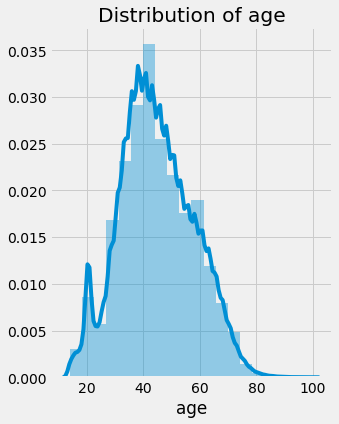

In [34]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (18 , 6))
n = 0 
for x in ['age']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(grp[x] , bins = 20)
    plt.title('Distribution of {}'.format(x))
plt.show()

## Select smaller sample

In [35]:
# Smaller sample chosen from the 1.6 million rows
# There is less cleaning so we use a bigger sample
agesample=grp[:50000]
agesample.head()

,ID,age,sex,agg_keywords
0,1,62,F,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...
1,2,35,M,restaurant:1;marrakech.shtml:1; expositions:1;...
2,3,45,F,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...
3,4,46,F,rigaud:3;laurent:3;photo:11;profile:8;photopro...
4,5,42,F,societe:1;disparition:1;proche:1;m%c3%a9lanie....


## Function to Classify Age by Decade

In [36]:
def label_age_group (row):
    if row['age'] < 10 :
        return 'Under 10'
    if row['age'] >= 10 and row['age'] <20 :
        return '10s'
    if row['age'] >= 20 and row['age'] <30 :
        return '20s'
    if row['age'] >= 30 and row['age'] <40 :
        return '30s'
    if row['age'] >= 40 and row['age'] <50 :
        return '40s'
    if row['age'] >= 50 and row['age'] <60 :
        return '50s'
    if row['age'] >= 60 and row['age'] <70 :
        return '60s'
    if row['age'] >= 70 and row['age'] <80 :
        return '70s'
    if row['age'] >= 80 :
        return 'Over 80'
    return 'Other'

In [37]:
agesample['age_group'] = agesample.apply(lambda row: label_age_group(row), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
agesample.head()

,ID,age,sex,agg_keywords,age_group
0,1,62,F,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...,60s
1,2,35,M,restaurant:1;marrakech.shtml:1; expositions:1;...,30s
2,3,45,F,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...,40s
3,4,46,F,rigaud:3;laurent:3;photo:11;profile:8;photopro...,40s
4,5,42,F,societe:1;disparition:1;proche:1;m%c3%a9lanie....,40s


## Model

In [39]:
#this part is for any text cleaning we want to do
def normalize_text(s):
    # just in case
    s = str(s)
    s = s.lower()
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W\s',' ',s)
    # make sure we didn't introduce any double spaces
    s = re.sub('\s+',' ',s)
    return s

agesample['text_norm'] = [normalize_text(s) for s in agesample['agg_keywords']]
agesample=agesample.drop(['agg_keywords'],axis=1)
agesample.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,ID,age,sex,age_group,text_norm
0,1,62,F,60s,fibre:16;quoi:1;dangers:1;combien:1;hightech:1...
1,2,35,M,30s,restaurant:1;marrakech.shtml:1 expositions:1;b...
2,3,45,F,40s,payer:1;faq:1;taxe:1;habitation:1;macron:1;qui...
3,4,46,F,40s,rigaud:3;laurent:3;photo:11;profile:8;photopro...
4,5,42,F,40s,societe:1;disparition:1;proche:1;m%c3%a9lanie....


In [40]:
# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(agesample['text_norm'])

encoder = LabelEncoder()
y = encoder.fit_transform(agesample['age_group'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [41]:
# Naive Bayes
nb2 = MultinomialNB()
nb2.fit(x_train, y_train)
print(nb2.score(x_test, y_test))

0.2887


In [42]:
# MLPC Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x_train, y_train)
print(clf.score(x_test, y_test))

0.3137
